# Multipoint ICMEs in the Solar Orbiter era

Notebook for the results and plots shown in the paper Möstl et al. 2021 ApJ (in prep.).

https://github.com/helioforecast/Papers/tree/master/Moestl2021_multipoint

Authors: C. Möstl, IWF Graz, Austria https://twitter.com/chrisoutofspace 

**work in progress, last update August 2021**

To install a conda environment, dependencies are listed under environment.yml, and pip in requirements.txt. Plots are saved in folder "plots" as png and pdf. 


**Data sources**

The ICME catalog ICMECATv2.0 (updated 2021 Apr 29) is included in this repository in folder "data". The latest versions can be downloaded from https://doi.org/10.6084/m9.figshare.6356420 or https://helioforecast.space/icmecat

The CME arrival catalog (based on STEREO heliospheric imager observations) ARRCATv2.0 (updated 2021-Apr-23) is included in the folder "data". Latest versions can be obtained from either: https://helioforecast.space/arrcat or https://doi.org/10.6084/m9.figshare.12271292 

If needed, in situ data needs to be downloaded into a directory defined in config.py from this figshare repository: https://doi.org/10.6084/m9.figshare.11973693.v10


---

**MIT LICENSE**

Copyright 2021, Christian Moestl

Permission is hereby granted, free of charge, to any person obtaining a copy of this 
software and associated documentation files (the "Software"), to deal in the Software
without restriction, including without limitation the rights to use, copy, modify, 
merge, publish, distribute, sublicense, and/or sell copies of the Software, and to 
permit persons to whom the Software is furnished to do so, subject to the following 
conditions:

The above copyright notice and this permission notice shall be included in all copies 
or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, 
INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A
PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT 
HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF 
CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE 
OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.





In [15]:
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc
import seaborn as sns
import numpy as np
import scipy.io
from scipy import stats
import sys
from datetime import timedelta
import time
import pickle
import os
import copy
import urllib
import json
import warnings
import importlib

import heliocats.data as hd

import sunpy
import sunpy.time
from sunpy.time import parse_time

import heliopy.spice as spice
import heliopy.data.spice as spicedata

import astropy
import astropy.constants as const

#our own packages
import py3dcore
import heliosat

#where the 6 in situ data files are located is read from input.py
#as data_path=....
from config import data_path

#Convert this notebook to a script with jupyter nbconvert --to script cme_rate.ipynb
os.system('jupyter nbconvert --to script cme_sig.ipynb')    

#%matplotlib inline
#matplotlib.use('Qt5Agg')
#matplotlib.use('Agg')
#warnings.filterwarnings('ignore') # some numpy mean-of-empty-slice runtime warnings

########### make directories first time
resdir='plots'
if os.path.isdir(resdir) == False: os.mkdir(resdir)

datadir='data'
if os.path.isdir(datadir) == False: os.mkdir(datadir)

plt.rcParams["figure.figsize"] = (15,8)
plt.close('all')

#constants: 
#solar radius
Rs_in_AU=float(const.R_sun/const.au)
#define AU in km
AU_in_km=const.au.value/1e3


print('sunpy:',sunpy.__version__)
print('astropy:',astropy.__version__)

print('done')

sunpy: 1.1.0
astropy: 4.0
done


In [2]:
########### load ICMECAT v2.0, made with icmecat.py or ipynb
file='icmecat/HELCATS_ICMECAT_v20_pandas.p'
print()
print('loaded ', file)
print()
print('Keys (parameters) in this pandas data frame are:')

[ic,h,p]=pickle.load(open(file, "rb" ) )  
print(ic.keys())
print()


loaded  icmecat/HELCATS_ICMECAT_v20_pandas.p

Keys (parameters) in this pandas data frame are:
Index(['icmecat_id', 'sc_insitu', 'icme_start_time', 'mo_start_time',
       'mo_end_time', 'mo_sc_heliodistance', 'mo_sc_long_heeq',
       'mo_sc_lat_heeq', 'icme_duration', 'icme_bmax', 'icme_bmean',
       'icme_bstd', 'icme_speed_mean', 'icme_speed_std', 'mo_duration',
       'mo_bmax', 'mo_bmean', 'mo_bstd', 'mo_bzmean', 'mo_bzmin', 'mo_bzstd',
       'mo_bymean', 'mo_bystd', 'mo_speed_mean', 'mo_speed_std',
       'mo_expansion_speed', 'mo_pdyn_mean', 'mo_pdyn_std', 'mo_density_mean',
       'mo_density_std', 'mo_temperature_mean', 'mo_temperature_std',
       'sheath_speed_mean', 'sheath_speed_std', 'sheath_density_mean',
       'sheath_density_std', 'sheath_pdyn_mean', 'sheath_pdyn_std'],
      dtype='object')



In [3]:
ic

,icmecat_id,sc_insitu,icme_start_time,mo_start_time,mo_end_time,mo_sc_heliodistance,mo_sc_long_heeq,mo_sc_lat_heeq,icme_duration,icme_bmax,...,mo_density_mean,mo_density_std,mo_temperature_mean,mo_temperature_std,sheath_speed_mean,sheath_speed_std,sheath_density_mean,sheath_density_std,sheath_pdyn_mean,sheath_pdyn_std
0,ICME_STEREO_A_MOESTL_20210619_01,STEREO-A,2021-06-19 20:44:00,2021-06-20 01:30:00,2021-06-21 06:29:00,0.9615,-48.30,-4.21,33.75,11.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ICME_STEREO_A_MOESTL_20210526_01,STEREO-A,2021-05-26 06:11:00,2021-05-26 06:11:00,2021-05-27 22:25:00,0.9639,-50.64,-6.42,40.23,17.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ICME_BEPI_MOESTL_20210525_01,BepiColombo,2021-05-25 00:27:00,2021-05-25 00:27:00,2021-05-26 04:42:00,0.7882,-111.90,-3.24,28.25,15.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ICME_Wind_MOESTL_20210512_01,Wind,2021-05-12 05:54:00,2021-05-12 14:44:00,2021-05-13 13:38:00,1.0018,-0.08,-2.99,31.73,23.2,...,4.5,2.8,187458.8,92667.1,444.1,15.8,19.8,11.6,6.5,3.8
4,ICME_BEPI_MOESTL_20210508_01,BepiColombo,2021-05-08 18:34:00,2021-05-09 02:24:00,2021-05-10 00:22:00,0.7313,-118.32,-2.24,29.80,18.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
803,ICME_VEX_SGOOD_20070213_01,VEX,2007-02-13 14:40:00,2007-02-13 14:40:00,2007-02-14 09:33:00,0.7245,-117.25,2.83,18.88,19.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
804,ICME_Wind_NASA_20070115_01,Wind,2007-01-15 20:49:00,2007-01-15 20:49:00,2007-01-16 04:45:00,0.9731,0.15,-4.57,7.93,10.4,...,4.1,1.4,97358.1,37602.1,NaN,NaN,NaN,NaN,NaN,NaN
805,ICME_STEREO_B_JIAN_20070114_01,STEREO-B,2007-01-14 12:24:00,2007-01-14 13:59:00,2007-01-15 07:37:00,0.9791,0.02,-4.52,19.22,14.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
806,ICME_STEREO_A_JIAN_20070114_01,STEREO-A,2007-01-14 12:11:00,2007-01-14 14:39:00,2007-01-15 07:34:00,0.9727,0.26,-4.61,19.38,14.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#load HIGeoCAT
from heliocats import cats as hc
importlib.reload(hc) #reload again while debugging 

#https://www.helcats-fp7.eu/
#LOAD HELCATS HIGeoCAT
url_higeocat='https://www.helcats-fp7.eu/catalogues/data/HCME_WP3_V06.vot'

try: urllib.request.urlretrieve(url_higeocat,'data/HCME_WP3_V06.vot')
except urllib.error.URLError as e:
    print('higeocat not loaded')

higeocat=hc.load_higeocat_vot('data/HCME_WP3_V06.vot')
higeocat_time=parse_time(higeocat['Date']).datetime    
higeocat_t0=parse_time(higeocat['SSE Launch']).datetime   #backprojected launch time

sse_speed=higeocat['SSE Speed']
sse_lon=higeocat['SSE HEEQ Long']
sse_lat=higeocat['SSE HEEQ Lat']
higeocat_name=np.array(higeocat['SC'].astype(str))
higeocat_id=np.array(higeocat['ID'].astype(str))



print('done')

done


In [5]:
#CACTUS
url_cactus='https://wwwbis.sidc.be/cactus/catalog/LASCO/2_5_0/cmecat_combo.sav'

try: urllib.request.urlretrieve(url_cactus,'data/LASCO_CME/cmecat_combo.sav')
except urllib.error.URLError as e:
    print('lasco cme not loaded')


#LASCO CME catalog 
url_lasco='https://cdaw.gsfc.nasa.gov/CME_list/UNIVERSAL/text_ver/univ_all.txt'

try: urllib.request.urlretrieve(url_lasco,'data/LASCO_CME/univ_all.txt')
except urllib.error.URLError as e:
    print('lasco cme not loaded')

In [6]:
#read lasco catalog

la=np.genfromtxt('data/LASCO_CME/univ_all.txt',dtype=(str), usecols=[0,1,2,3,4,5,6,7,8,9,10,11],skip_header=4)

la_time=[]
cpa=np.zeros(len(la))
width=np.zeros(len(la))
speedlin=np.zeros(len(la))

# ========= SOHO/LASCO CME CATALOG==========      LAST UPDATED: 2021/08/09 13:39
# Date       Time     Central  Width  Linear   2nd order speed      Accel     Mass      Kinetic    MPA   Remarks
#                        PA           Speed  initial final   20R                        Energy                 

for i in np.arange(0,len(la)):
    #convert time from string to datetime
    la_time.append(parse_time(la[i][0]+' '+la[i][1]).isot)
    
    
    if la[i][2]=='Halo': 
        cpa[i]=360
    else:
        cpa[i]=float(la[i][2])

    width[i]=int(la[i][3])
    
    if la[i][4]=='----':
        speedlin[i]=np.nan
    else:
        speedlin[i]=int(la[i][4])

#print(la_time)
#print(cpa)
#print(width)
#print(speedlin)

data=np.vstack([parse_time(la_time).datetime,cpa,width,speedlin])
# Create the pandas DataFrame
ldf = pd.DataFrame(data.transpose(), columns = ['time','cpa','width','speed'])
                                   




## Create multipoint CME catalog

In [7]:
#define Events from ICMECAT, add HIGEOcat if connection to in situ is evident
#HI arrival within +/- 24 hours at 1 AU

#add identified events from  HIGEOCAT and/or CACTUS


#get indices in ICMECAT and HIGEOCAT
def get_cat_ind(event_list,event_type):
    event_ind=[]
    for i in np.arange(len(event_list)):        
        
        #LASCO
        #if event_type[i]==2:
        #    event_ind.append(np.where(ldf.time==event_list[i])[0][0])
            
        #HICAT    
        if event_type[i]==0:
            #print('hicat')
            event_ind.append(np.where(higeocat_id==event_list[i])[0][0])
            
        #ICMECAT    
        if event_type[i]==1:            
            #print('icmecat')
            event_ind.append(np.where(ic.icmecat_id==event_list[i])[0][0])
            
    return event_ind    


event_all=[]
event_all_ind=[]
event_all_type=[]



#### 1
#time in lasco cat - get from online catalog
cme_start=datetime.datetime(2020,4,15,0,18,20)
event_ind_lasco=np.where(ldf.time==cme_start)[0][0]
l_id=parse_time(cme_start).iso
print('Event 1 cpa, width, speed,', ldf.cpa[event_ind_lasco],ldf.width[event_ind_lasco], ldf.speed[event_ind_lasco])


event=['HCME_A__20200415_01',
       'ICME_SOLO_MOESTL_20200419_01', 
       'ICME_Wind_MOESTL_20200420_01', 
       'ICME_BEPI_MOESTL_20200420_01']
#0 for imaging, 1 for in situ
event_type=[0,1,1,1]
event_ind=get_cat_ind(event,event_type)
event_all.extend(event)
event_all_ind.extend(event_ind)
event_all_type.extend(event_type)

### 2
event=['HCME_A__20200526_01',
        'ICME_SOLO_MOESTL_20200528_01', 
        'ICME_Wind_MOESTL_20200529_01', 
        'ICME_BEPI_MOESTL_20200529_01']
#0 for imaging, 1 for in situ
event_type=[0,1,1,1]
event_ind=get_cat_ind(event,event_type)
event_all.extend(event)
event_all_ind.extend(event_ind)
event_all_type.extend(event_type)


### 3
event=['HCME_A__20200527_01',
       'ICME_STEREO_A_MOESTL_20200603_01' ]
#0 for imaging, 1 for in situ
event_type=[0,1]
event_ind=get_cat_ind(event,event_type)
event_all.extend(event)
event_all_ind.extend(event_ind)
event_all_type.extend(event_type)




#### 4
event=['HCME_A__20200623_01',
        'ICME_PSP_MOESTL_20200625_01', 
        'ICME_BEPI_MOESTL_20200629_01', 
        'ICME_Wind_MOESTL_20200701_01']
#0 for imaging, 1 for in situ
event_type=[0,1,1,1]
event_ind=get_cat_ind(event,event_type)
event_all.extend(event)
event_all_ind.extend(event_ind)
event_all_type.extend(event_type)

### 5
event=['HCME_A__20200706_01',
        'ICME_STEREO_A_MOESTL_20200709_01']
#0 for imaging, 1 for in situ
event_type=[0,1]
event_ind=get_cat_ind(event,event_type)
event_all.extend(event)
event_all_ind.extend(event_ind)
event_all_type.extend(event_type)



### 6
event=['HCME_A__20200816_01',
       'ICME_STEREO_A_MOESTL_20200819_01']
#0 for imaging, 1 for in situ
event_type=[0,1]
event_ind=get_cat_ind(event,event_type)
event_all.extend(event)
event_all_ind.extend(event_ind)
event_all_type.extend(event_type)




### 7
event=['HCME_A__20200908_01',
       'ICME_PSP_MOESTL_20200912_01']
#0 for imaging, 1 for in situ
event_type=[0,1]
event_ind=get_cat_ind(event,event_type)
event_all.extend(event)
event_all_ind.extend(event_ind)
event_all_type.extend(event_type)



### 8
event=['HCME_A__20200930_01',
        'ICME_Wind_MOESTL_20201005_01' ]
#0 for imaging, 1 for in situ
event_type=[0,1]
event_ind=get_cat_ind(event,event_type)
event_all.extend(event)
event_all_ind.extend(event_ind)
event_all_type.extend(event_type)







### 9  **MERGER
event=['HCME_A__20201006_01',
       'ICME_BEPI_MOESTL_20201008_01',
       'ICME_BEPI_MOESTL_20201010_01']
#0 for imaging, 1 for in situ
event_type=[0,1,1]
event_ind=get_cat_ind(event,event_type)
event_all.extend(event)
event_all_ind.extend(event_ind)
event_all_type.extend(event_type)





#### 10
#time in lasco cat - get from online catalog
cme_start=datetime.datetime(2020,11,29,13,25,49)
event_ind_lasco=np.where(ldf.time==cme_start)[0][0]
l_id=parse_time(cme_start).iso
print('Event 10 cpa, width, speed,', ldf.cpa[event_ind_lasco],ldf.width[event_ind_lasco], ldf.speed[event_ind_lasco])



#####10
event=[ 'ICME_PSP_MOESTL_20201201_01',
        'ICME_STEREO_A_MOESTL_20201201_01'        ]
#0 for imaging, 1 for in situ
event_type=[1,1]
event_ind=get_cat_ind(event,event_type)
event_all.extend(event)
event_all_ind.extend(event_ind)
event_all_type.extend(event_type)




#####11  * *MERGER
event=['HCME_A__20201129_01',
       'HCME_A__20201201_01',
        'ICME_STEREO_A_MOESTL_20201203_01' ]#****add 2nd ICME shortly before this one
#0 for imaging, 1 for in situ
event_type=[0,0,1]
event_ind=get_cat_ind(event,event_type)
event_all.extend(event)
event_all_ind.extend(event_ind)
event_all_type.extend(event_type)


#####12
event=['HCME_A__20210211_01',
        'ICME_Wind_MOESTL_20210215_01' ]
#0 for imaging, 1 for in situ
event_type=[0,1]
event_ind=get_cat_ind(event,event_type)
event_all.extend(event)
event_all_ind.extend(event_ind)
event_all_type.extend(event_type)


#####13
event=['HCME_A__20210220_01',
       'ICME_STEREO_A_MOESTL_20210223_01',
       'ICME_Wind_MOESTL_20210224_01']
#0 for imaging, 1 for in situ
event_type=[0,1,1]
event_ind=get_cat_ind(event,event_type)
event_all.extend(event)
event_all_ind.extend(event_ind)
event_all_type.extend(event_type)


#####14
event=['HCME_A__20210322_01',
       'ICME_Wind_MOESTL_20210326_01']
#0 for imaging, 1 for in situ
event_type=[0,1]
event_ind=get_cat_ind(event,event_type)
event_all.extend(event)
event_all_ind.extend(event_ind)
event_all_type.extend(event_type)


#####15
event=['HCME_A__20210331_01',
       'ICME_Wind_MOESTL_20210404_01',
       'ICME_STEREO_A_MOESTL_20210406_01',
       ]
#0 for imaging, 1 for in situ
event_type=[0,1,1]
event_ind=get_cat_ind(event,event_type)
event_all.extend(event)
event_all_ind.extend(event_ind)
event_all_type.extend(event_type)



#####16
event=['HCME_A__20210410_01',
       'ICME_Wind_MOESTL_20210415_01',
       ]
#0 for imaging, 1 for in situ
event_type=[0,1]
event_ind=get_cat_ind(event,event_type)
event_all.extend(event)
event_all_ind.extend(event_ind)
event_all_type.extend(event_type)

#####17
event=['HCME_A__20210410_01',
       'ICME_Wind_MOESTL_20210512_01',
       ]
#0 for imaging, 1 for in situ
event_type=[0,1]
event_ind=get_cat_ind(event,event_type)
event_all.extend(event)
event_all_ind.extend(event_ind)
event_all_type.extend(event_type)




#event 18
#ICME_STEREO_A_MOESTL_20210526_01	
#und Wind



#make event numbering array (1,1,1,2,2,2,...)
event_numbering=[1,1,1,1,2,2,2,2,3,3, 4,4,4,4, 5,5, 6,6,7,7 ,
                 8,8,9,9,9,10,10,11,11,11,12,12,13,13,13,14,14,15,15,15,16,16,17,17]



#### build up data frame
data=[]
for i in np.arange(0,len(event_all),1):
    
    #HI
    if event_all_type[i]==0:
        
        #HI time when it appears in HI1?
        hi_time=parse_time(higeocat['Date'][event_all_ind[i]].decode("utf-8")).datetime
        
        ############# generate STEREO-A position
        spice.furnish(spicedata.get_kernel('stereo_a'))
        sta=spice.Trajectory('-234')  
        sta.generate_positions([hi_time,hi_time],'Sun','HEEQ')  
        sta.change_units(astropy.units.AU)  
        [sta_r, sta_lat, sta_lon]=hd.cart2sphere(sta.x,sta.y,sta.z)
        #print('STEREO-A') 
        #print(sta_r[0])
        #print(np.rad2deg(sta_lon[0]))


        data.append([event_numbering[i], hi_time, 
                    'HIA',
                     np.round(sta_r[0],3),
                     np.round(np.rad2deg(sta_lon[0]),1),
                    sse_lon[event_all_ind[i]],
                    sse_speed[event_all_ind[i]],
                     '-',
                     '-',
                    higeocat_id[event_all_ind[i]] 
                    ] )


    #HI    
    #in situ 
    if event_all_type[i]==1:
        
        #to avoid NaN in the table
        speed=np.rint(ic.icme_speed_mean[event_all_ind[i]])
        #print(speed)
        if np.isnan(speed): speed='-'


        data.append([event_numbering[i], ic.icme_start_time[event_all_ind[i]], 
                    ic.sc_insitu[event_all_ind[i]],
                    np.round(ic.mo_sc_heliodistance[event_all_ind[i]],3),                     
                    np.round(ic.mo_sc_long_heeq[event_all_ind[i]],1),    
                    '-',    
                    speed, 
                    ic.mo_bmax[event_all_ind[i]],
                    ic.mo_bzmin[event_all_ind[i]],                    
                    ic.icmecat_id[event_all_ind[i]]  
                    ] )
  
 
    
  
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ['event', 'start time','spacecraft','R [AU]','sc long. [HEEQ]','CME long. [HEEQ]','speed [km/s]','Bt max [nT]','Bz min [nT]','id'] )

#df= df.drop(columns='id')

df = df.reset_index(drop=True)

df2=copy.deepcopy(df)
#make latex table - remove id and all after 2021 March 31
df2= df2.drop(columns='id')
df2=df2.drop([42,43 ])
df2.to_latex(buf='lineups/table_insitu.txt',index=False)  
    
# print dataframe.
df

Event 1 cpa, width, speed, 276.0 104.0 80.0
Event 10 cpa, width, speed, 360.0 360.0 2077.0


,event,start time,spacecraft,R [AU],sc long. [HEEQ],CME long. [HEEQ],speed [km/s],Bt max [nT],Bz min [nT],id
0,1,2020-04-15 20:49:00,HIA,0.967,-75.4,-6,339,-,-,HCME_A__20200415_01
1,1,2020-04-19 05:06:00,SolarOrbiter,0.808,-4.0,-,-,21.2,-19.2,ICME_SOLO_MOESTL_20200419_01
2,1,2020-04-20 01:34:00,Wind,0.996,0.2,-,346,16.2,-15.1,ICME_Wind_MOESTL_20200420_01
3,1,2020-04-20 03:09:00,BepiColombo,1.011,-1.3,-,-,16.1,-14.4,ICME_BEPI_MOESTL_20200420_01
4,2,2020-05-26 01:29:00,HIA,0.966,-72.3,36,497,-,-,HCME_A__20200526_01
5,2,2020-05-28 12:45:00,SolarOrbiter,0.564,28.2,-,-,28.2,-26.6,ICME_SOLO_MOESTL_20200528_01
6,2,2020-05-29 21:20:00,Wind,1.005,-0.2,-,350,14.5,-12.4,ICME_Wind_MOESTL_20200529_01
7,2,2020-05-29 15:27:00,BepiColombo,0.977,-5.2,-,-,13.1,-11.5,ICME_BEPI_MOESTL_20200529_01
8,3,2020-05-27 04:49:00,HIA,0.966,-72.2,-47,315,-,-,HCME_A__20200527_01
9,3,2020-06-03 07:54:00,STEREO-A,0.965,-71.5,-,373,9.9,-4.6,ICME_STEREO_A_MOESTL_20200603_01


## In situ plots


In [9]:
print('load data RTN') 
filepsp='psp_2018_2021_rtn_new.p'
[psp,hpsp]=pickle.load(open(data_path+filepsp, "rb" ) ) 
    
filewin="wind_2018_now_heeq.p" 
[win,hwin]=pickle.load(open(data_path+filewin, "rb" ) )  

filesta='stereoa_2020_now_rtn_beacon.p'
[sta,hsta]=pickle.load(open(data_path+filesta, "rb" ) )  

filebepi='bepi_2019_2021_rtn.p'
bepi=pickle.load(open(data_path+filebepi, "rb" ) ) 
    

load data RTN


### 2020 Nov event

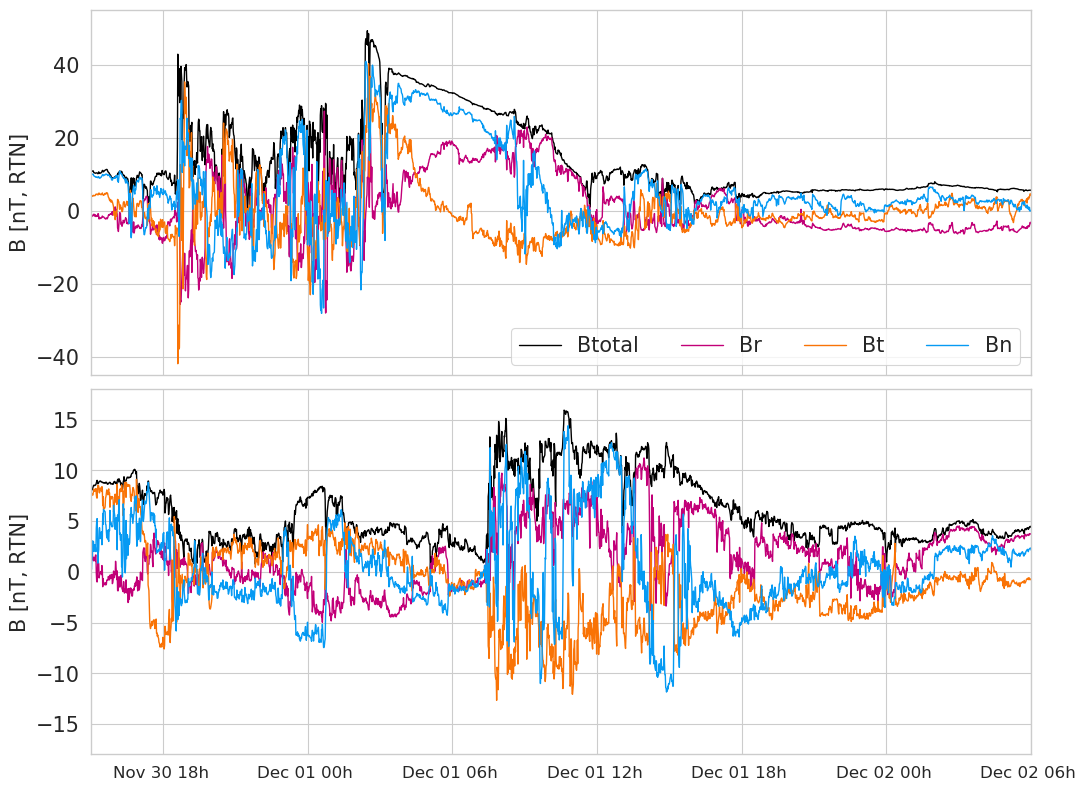

In [70]:
sns.set_style('whitegrid')
sns.set_context('paper')

plt.figure(1,figsize=(11, 8),dpi=100)

#define subplot grid
ax1 = plt.subplot2grid((2, 1), (0, 0))  
ax2 = plt.subplot2grid((2, 1), (1, 0))  

## PSP
plotstart=datetime.datetime(2020,11,30,15)
plotend=datetime.datetime(2020,12,2,6)
blim=55


ax1.plot(psp.time, psp.bt, "k-", lw=1,label='Btotal')
ax1.plot(psp.time, psp.bx, "r-", color="xkcd:magenta", lw=1, label='Br')
ax1.plot(psp.time, psp.by, "g-", color="xkcd:orange", lw=1,label='Bt')
ax1.plot(psp.time, psp.bz, "b-", color="xkcd:azure", lw=1,label='Bn')
    
#plot vertical lines
#ax1.plot_date([sicme_start_time,sicme_start_time],[-500,500],'-k',linewidth=1)            
#ax1.plot_date([smo_start_time,smo_start_time],[-500,500],'-k',linewidth=1)            
#ax1.plot_date([smo_end_time,smo_end_time],[-500,500],'-k',linewidth=1)            

ax1.set_ylabel('B [nT, RTN]',fontsize=15)
ax1.set_xlim(plotstart,plotend)
ax1.set_ylim(-blim+10,blim)
ax1.legend(loc=4,ncol=4,fontsize=15)
ax1.grid(True)
ax1.set_xticklabels([])
ax1.tick_params(axis='y', labelsize=15)
ax1.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1/4))


### STA
blim=18
ax2.plot(sta.time, sta.bt, "k-", lw=1,label='Btotal')
ax2.plot(sta.time, sta.bx, "r-", color="xkcd:magenta", lw=1, label='Br')
ax2.plot(sta.time, sta.by, "g-", color="xkcd:orange", lw=1,label='Bt')
ax2.plot(sta.time, sta.bz, "b-", color="xkcd:azure", lw=1,label='Bn')
    
ax2.set_ylabel('B [nT, RTN]',fontsize=15)
ax2.set_xlim(plotstart,plotend)
ax2.set_ylim(-blim,blim)
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=15)
#ax2.legend(loc=1,ncol=4,fontsize=15)
ax2.grid(True)
ax2.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d %Hh ') )
ax2.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1/4))

plt.tight_layout()

plt.savefig('lineups/figure_psp_sta_2020_nov_event.png')
plt.savefig('lineups/figure_psp_sta_2020_nov_event.pdf')


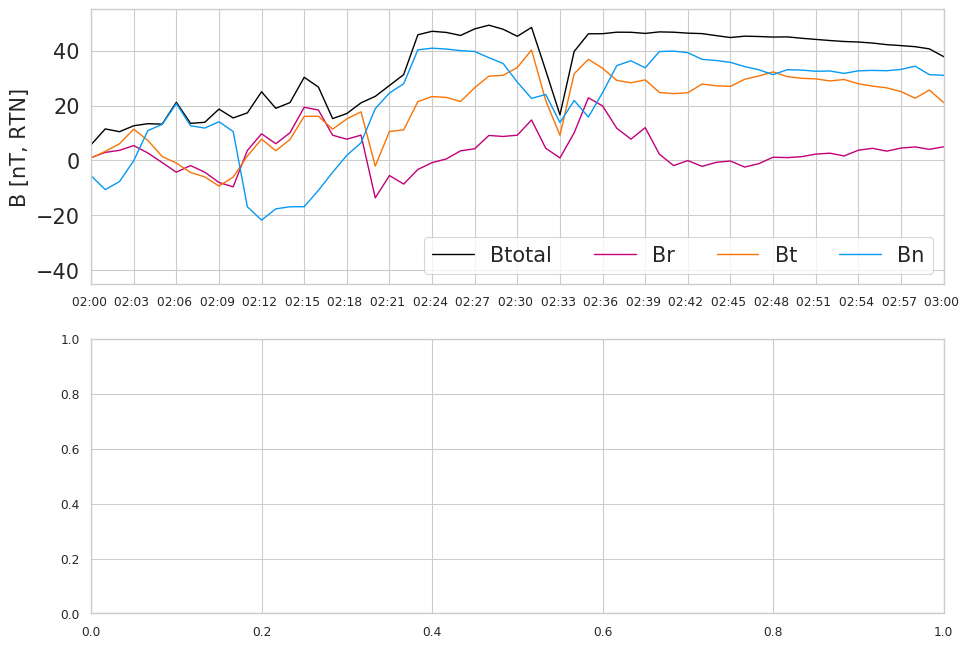

In [90]:
##close up
sns.set_style('whitegrid')
sns.set_context('paper')

plt.figure(1,figsize=(11, 8),dpi=100)

#define subplot grid
ax1 = plt.subplot2grid((2, 1), (0, 0))  
ax2 = plt.subplot2grid((2, 1), (1, 0))  

## PSP
#first shock
#plotstart=datetime.datetime(2020,11,30,18)
#plotend=datetime.datetime(2020,11,30,19)

plotstart=datetime.datetime(2020,12,1,2)
plotend=datetime.datetime(2020,12,1,3)

blim=55


ax1.plot(psp.time, psp.bt, "k-", lw=1,label='Btotal')
ax1.plot(psp.time, psp.bx, "r-", color="xkcd:magenta", lw=1, label='Br')
ax1.plot(psp.time, psp.by, "g-", color="xkcd:orange", lw=1,label='Bt')
ax1.plot(psp.time, psp.bz, "b-", color="xkcd:azure", lw=1,label='Bn')
    
#plot vertical lines
#ax1.plot_date([sicme_start_time,sicme_start_time],[-500,500],'-k',linewidth=1)            
#ax1.plot_date([smo_start_time,smo_start_time],[-500,500],'-k',linewidth=1)            
#ax1.plot_date([smo_end_time,smo_end_time],[-500,500],'-k',linewidth=1)            

ax1.set_ylabel('B [nT, RTN]',fontsize=15)
ax1.set_xlim(plotstart,plotend)
ax1.set_ylim(-blim+10,blim)
ax1.legend(loc=4,ncol=4,fontsize=15)
ax1.grid(True)
#ax1.set_xticklabels([])
ax1.tick_params(axis='y', labelsize=15)
#ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d %Hh ') )
ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M ') )
ax1.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1/(24*20)))

## June 2020 event


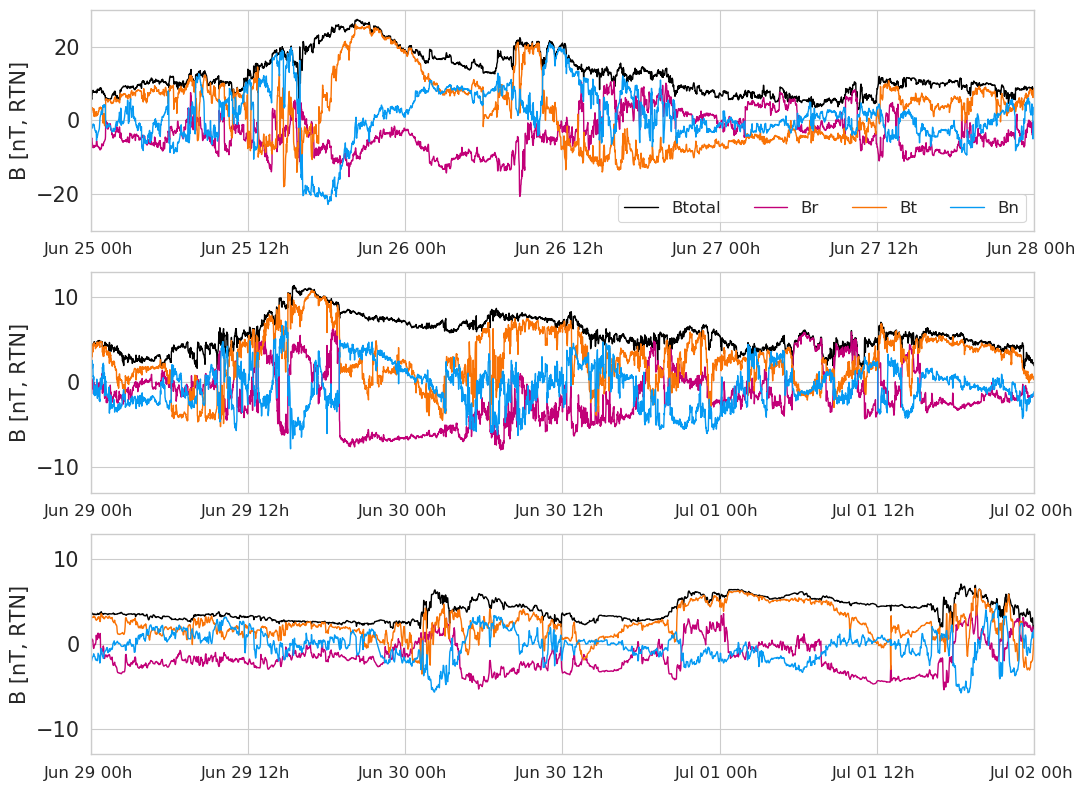

In [106]:
sns.set_style('whitegrid')
sns.set_context('paper')

plt.figure(1,figsize=(11, 8),dpi=100)

#define subplot grid
ax1 = plt.subplot2grid((3, 1), (0, 0))  
ax2 = plt.subplot2grid((3, 1), (1, 0))  
ax3 = plt.subplot2grid((3, 1), (2, 0))  



## PSP
plotstart=datetime.datetime(2020,6,25)
plotend=datetime.datetime(2020,6,28)
blim=30


ax1.plot(psp.time, psp.bt, "k-", lw=1,label='Btotal')
ax1.plot(psp.time, psp.bx, "r-", color="xkcd:magenta", lw=1, label='Br')
ax1.plot(psp.time, psp.by, "g-", color="xkcd:orange", lw=1,label='Bt')
ax1.plot(psp.time, psp.bz, "b-", color="xkcd:azure", lw=1,label='Bn')
    
#plot vertical lines
#ax1.plot_date([sicme_start_time,sicme_start_time],[-500,500],'-k',linewidth=1)            
#ax1.plot_date([smo_start_time,smo_start_time],[-500,500],'-k',linewidth=1)            
#ax1.plot_date([smo_end_time,smo_end_time],[-500,500],'-k',linewidth=1)            

ax1.set_ylabel('B [nT, RTN]',fontsize=15)
ax1.set_xlim(plotstart,plotend)
ax1.set_ylim(-blim,blim)
ax1.legend(loc=4,ncol=4,fontsize=12)
ax1.grid(True)
ax1.tick_params(axis='y', labelsize=15)
ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d %Hh ') )
ax1.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1/2))
ax1.tick_params(axis='x', labelsize=12)

### Bepi
blim=13

plotstart=datetime.datetime(2020,6,29)
plotend=datetime.datetime(2020,7,2)


ax2.plot(bepi.time, bepi.bt, "k-", lw=1,label='Btotal')
ax2.plot(bepi.time, bepi.bx, "r-", color="xkcd:magenta", lw=1, label='Br')
ax2.plot(bepi.time, bepi.by, "g-", color="xkcd:orange", lw=1,label='Bt')
ax2.plot(bepi.time, bepi.bz, "b-", color="xkcd:azure", lw=1,label='Bn')
    
ax2.set_ylabel('B [nT, RTN]',fontsize=15)
ax2.set_xlim(plotstart,plotend)
ax2.set_ylim(-blim,blim)
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=15)
#ax2.legend(loc=1,ncol=4,fontsize=15)
ax2.grid(True)
ax2.set_xticklabels([])
ax2.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d %Hh ') )
ax2.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1/2))


### Wind
blim=13
plotstart=datetime.datetime(2020,6,29)
plotend=datetime.datetime(2020,7,2)


ax3.plot(win.time, win.bt, "k-", lw=1,label='Btotal')
ax3.plot(win.time, win.bx, "r-", color="xkcd:magenta", lw=1, label='Br')
ax3.plot(win.time, win.by, "g-", color="xkcd:orange", lw=1,label='Bt')
ax3.plot(win.time, win.bz, "b-", color="xkcd:azure", lw=1,label='Bn')
    
ax3.set_ylabel('B [nT, RTN]',fontsize=15)
ax3.set_xlim(plotstart,plotend)
ax3.set_ylim(-blim,blim)
ax3.tick_params(axis='x', labelsize=12)
ax3.tick_params(axis='y', labelsize=15)
#ax2.legend(loc=1,ncol=4,fontsize=15)
ax3.grid(True)
ax3.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d %Hh ') )
ax3.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1/2))

plt.tight_layout()


plt.savefig('lineups/figure_2020_june_event.png')
plt.savefig('lineups/figure_2020_june_event.pdf')

